> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Before submitting your project, it will be a good idea to go back through your report and remove these sections to make the presentation of your work as tidy as possible. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset (Replace this with something more specific!)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project I use Movie Data. This dataset contains information about 10,000 movies collected from The Movie Database (TMDb). Contains data such as title, cast, director, runtime, budget, revenue, release year etc.

Certain columns, like ‘cast’ and ‘genres’, contain multiple values separated by pipe (|) characters.
The final two columns ending with “_adj" show the budget and revenue of the associated movie in terms of 2010 dollars, accounting for inflation over time.



Research Question

Questions in the projects are as follows:

Part 1: General
Which movie earns the highest and lowest profit?
Which movie have the highest and lowest revenue?
Which movie have the highest and lowest budget?
Which movie have the longest and shortest runtime?
How much movie released year by year?
How distribution of profit in different popularity levels in recent ten years?
How distribution of profit in different vote average levels in recent ten years?
Part 2: Find Associate Variable Movie Genre with Movie Metric
What movie genre that associated with popularity level?
What movie genre that associated with revenue level?
What movie genre that associated with vote average level?
What movie genre that associated with profit level?
Part 3: Find Some Trend¶
What is the trend of the genre every 10 years?


In [18]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re
from collections import Counter
%matplotlib inline

In [16]:
# Load data
df = pd.read_csv("tmdb-movies.csv")
#Print first row to see the example of data
df.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


In [11]:
#Find shape of data
r,c = df.shape
print("Dataset Movie Contains %d rows and %d columns" % (r,c))

Dataset Movie Contains 10866 rows and 21 columns




### Data Cleaning 

In this section I will find column that unnecessary for this research, find duplicate data, find missing data, and change some format data that can make this research easier.

Find Missing Value and Unnecessary Columns


In [12]:
# print the information about count of not null data value and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [ ]:
# list of unnecessary columns
col = ['imdb_id', 'homepage', 'tagline', 'overview']

# delete unnecessary columns
df.drop(col,axis=1,inplace=True)

In [13]:
# print statistical summary from numeric columns to find if any weird value
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


In [14]:
# print sample that have budget zero to know is this real zero or not
df.query('budget == 0').head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
30,280996,tt3168230,3.927333,0,29355203,Mr. Holmes,Ian McKellen|Milo Parker|Laura Linney|Hattie M...,http://www.mrholmesfilm.com/,Bill Condon,The man behind the myth,...,"The story is set in 1947, following a long-ret...",103,Mystery|Drama,BBC Films|See-Saw Films|FilmNation Entertainme...,6/19/15,425,6.4,2015,0.0,2.700677e+07


In [19]:
# change zero number to NA
zero_col = ['budget', 'revenue', 'runtime', 'budget_adj', 'revenue_adj']

# replace all zero value from to NAN in the list
df[zero_col] = df[zero_col].replace(0, np.NAN)

In [4]:
#creating a list of columb to be deleted
del_col=[ 'id', 'imdb_id', 'popularity', 'budget_adj', 'revenue_adj', 'homepage', 'keywords', 'overview', 'production_companies', 'vote_count', 'vote_average']


#deleting the columns
tmdb_data= tmdb_data.drop(del_col,1)

#previewing the new dataset
tmdb_data.head(4)

,budget,revenue,original_title,cast,director,tagline,runtime,genres,release_date,release_year
0,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,The park is open.,124,Action|Adventure|Science Fiction|Thriller,6/9/15,2015
1,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,What a Lovely Day.,120,Action|Adventure|Science Fiction|Thriller,5/13/15,2015
2,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,One Choice Can Destroy You,119,Adventure|Science Fiction|Thriller,3/18/15,2015
3,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,Every generation has a story.,136,Action|Adventure|Science Fiction|Fantasy,12/15/15,2015


In [21]:
# see the update info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  5170 non-null float64
revenue                 4850 non-null float64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10835 non-null float64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj           

In [23]:
# drop duplicate row in data
df.drop_duplicates(inplace=True)

# see the update info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 21 columns):
id                      10865 non-null int64
imdb_id                 10855 non-null object
popularity              10865 non-null float64
budget                  5169 non-null float64
revenue                 4849 non-null float64
original_title          10865 non-null object
cast                    10789 non-null object
homepage                2936 non-null object
director                10821 non-null object
tagline                 8041 non-null object
keywords                9372 non-null object
overview                10861 non-null object
runtime                 10834 non-null float64
genres                  10842 non-null object
production_companies    9835 non-null object
release_date            10865 non-null object
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj           

In [24]:
# change string to date format
df.release_date = pd.to_datetime(df['release_date'])

# see the update info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 21 columns):
id                      10865 non-null int64
imdb_id                 10855 non-null object
popularity              10865 non-null float64
budget                  5169 non-null float64
revenue                 4849 non-null float64
original_title          10865 non-null object
cast                    10789 non-null object
homepage                2936 non-null object
director                10821 non-null object
tagline                 8041 non-null object
keywords                9372 non-null object
overview                10861 non-null object
runtime                 10834 non-null float64
genres                  10842 non-null object
production_companies    9835 non-null object
release_date            10865 non-null datetime64[ns]
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj   

In [25]:
# the last data info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 21 columns):
id                      10865 non-null int64
imdb_id                 10855 non-null object
popularity              10865 non-null float64
budget                  5169 non-null float64
revenue                 4849 non-null float64
original_title          10865 non-null object
cast                    10789 non-null object
homepage                2936 non-null object
director                10821 non-null object
tagline                 8041 non-null object
keywords                9372 non-null object
overview                10861 non-null object
runtime                 10834 non-null float64
genres                  10842 non-null object
production_companies    9835 non-null object
release_date            10865 non-null datetime64[ns]
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj   



### Exploratory Data Analysis


In [27]:
# change numeric format to dollar format
def as_currency(amount):
    if amount >= 0:
        return '${:,.2f}'.format(amount) # return positive data in dollar version with 2 digit comas
    else: 
        return '-${:,.2f}'.format(-amount) # return negative data in dollar version with 2 digit comas

In [28]:
# get movie information
def get_movie_info(index, title):
    info = pd.DataFrame(df.loc[index]) # set some Data frame by index
    currency_col = ['budget', 'revenue', 'profit', 'budget_adj', 'revenue_adj', 'profit_adj'] # col that need to be currency
    # for each currency in list above,  do the following procedure
for idx in currency_col:
    info.loc[idx] = as_currency(info.loc[idx].item()) # change value number into currency format
    info.columns = [title] # change column name so it the reader will be clear what thats mean
    return info

SyntaxError: 'return' outside function (<ipython-input-28-b3d8041e64a1>, line 9)

In [ ]:
# get hihgest and lowes data information
def get_hi_low(column):
    # highest
    # get the index value of the highest number
    highest_idx = df[column].idxmax(skipna=True)
    ## get data from index before
    title = "Highest" + column
    highest_data = get_movie_info(highest_idx,title)
    
    # lowest
    ## get the index value of the highest number
    lowest_idx = df[column].idxmin(skipna=True)
    ## get data from index before
    title = "lowest" + column
    lowest_data = get_movie_info(lowest_idx,title)
    
    #concatenating two dataframes
    hi_low_data = pd.concat([highest_data, lowest_data], axis = 1)
    
    return hi_low_data<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (Replace this header name!)



<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (Replace this header name!)

<a id='eda'></a>
## General Questions:

1. Which movie earns the highest and lowest profit?


In [29]:
# add column profit in data
df['profit'] = df['revenue']-df['budget']
df['profit_adj'] = df['revenue_adj']-df['budget_adj']

# previewing the changes in the dataset
df.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit,profit_adj
0,135397,tt0369610,32.985763,150000000.0,1.513529e+09,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.363529e+09,1.254446e+09
1,76341,tt1392190,28.419936,150000000.0,3.784364e+08,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,2015-05-13,6185,7.1,2015,1.379999e+08,3.481613e+08,2.284364e+08,2.101614e+08
2,262500,tt2908446,13.112507,110000000.0,2.952382e+08,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,2015-03-18,2480,6.3,2015,1.012000e+08,2.716190e+08,1.852382e+08,1.704191e+08


In [30]:
# check the update data, kolom profit and profit_adj will have na value because some revenue and budget is na
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 23 columns):
id                      10865 non-null int64
imdb_id                 10855 non-null object
popularity              10865 non-null float64
budget                  5169 non-null float64
revenue                 4849 non-null float64
original_title          10865 non-null object
cast                    10789 non-null object
homepage                2936 non-null object
director                10821 non-null object
tagline                 8041 non-null object
keywords                9372 non-null object
overview                10861 non-null object
runtime                 10834 non-null float64
genres                  10842 non-null object
production_companies    9835 non-null object
release_date            10865 non-null datetime64[ns]
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj   

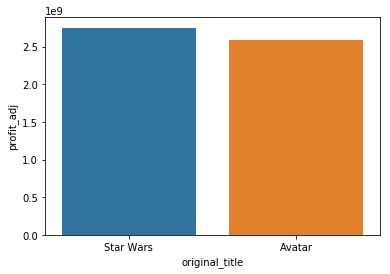

In [34]:
# visualize different profit_adj from Star Wars and Avatar
highest_profit = df[['original_title','profit_adj']].query("original_title in ['Star Wars','Avatar']")
sns.barplot(x="original_title", y="profit_adj", data=highest_profit)

In [36]:
# get number of movie group by release year
release = df.groupby('release_year').size()
# get index number of movie group by release year
release_idx = release.index

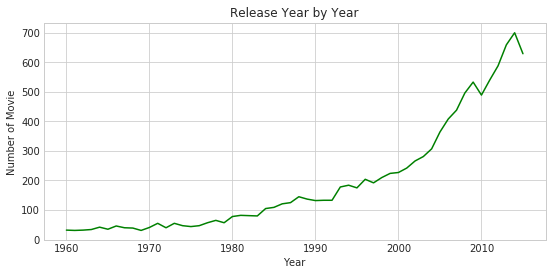

In [37]:
# visualisation
# set style
sns.set_style('whitegrid')
# set x, y axis data
x, y = release_idx, release
# set size
plt.figure(figsize=(9, 4))
# plot line chart for number of release
plt.plot(x, y, color = 'g', label = 'mean')
# set title and labels
plt.title('Release Year by Year')
plt.xlabel('Year')
plt.ylabel('Number of Movie');

<a id='eda'></a>
## Conclusion

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (Replace this header name!)

In [ ]:
<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (Replace this header name!)### Conclusions<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (Replace this header name!)
